## Laboratorio 1 - Procesamiento de Imagenes

El siguiente laboratorio introduce algunos de los conceptos básicos, en lo que concierne al Procesamiento de Imagenes. Para la siguiente experiencia se utilizara las siguientes librerías.

* __numpy__: Para el trabajo con operadores vectoriales.
* __matplotlib__: Visualización y diseño de gráficos.
* __skimage__: Lectura, escritura y obtención de imágenes.

#### Importaciones necesarias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data
from skimage.filters import threshold_niblack, threshold_sauvola, threshold_otsu, try_all_threshold

#### Definición de funciones a usar

In [2]:
def rgb_to_grayscale(image):
    """
    This function lets you transform an image from RGB to Grayscale.
    The returned variable is the input image transformed to gray, as
    a NumPy array.
    """
    gray = .299 * image[:,:,0] + .587 * image[:,:,1] + .114 * image[:,:,2]
    gray = np.array(gray, dtype=np.uint32)
    return gray

def grayscale_to_negative(image):
    """
    This function lets you transform an image from Grayscale to Negative.
    The returned variable is the input image in negative, as a NumPy array.
    """
    negative = None
    if np.max(image) > 1: negative = np.array(255 - image, dtype=np.uint8)
    else: negative = np.array(1 - image, dtype=np.uint8)
    return negative

def get_binarized_image(image, threshold):
    """
    This function binarize an image depending of the given threshold value.
    The returned variable is the input image binarized, as a NumPy array.
    """
    binary = image > threshold
    return np.array(binary)

def obtain_histogram(image, cumulative=False):
    """
    This function obtains either normal or cumulativa histogram for an image.
    Returns a vector whose index positions represent a grayscale intensity and
    contains every corresponding count.
    """
    histogram = np.zeros(256, dtype=np.uint32)
    for i in range(0,256):
        histogram[i] = np.count_nonzero(image == i) 
        
    # Case when user wants the cumulative function.
    if cumulative:
        for i in np.arange(1, 256):
            histogram[i] += histogram[i-1]
    return histogram

def plot_histogram(image):
    """
    This function plots the corresponding histogram for the given image.
    """
    fig, axes = plt.subplots(1,2, figsize=(8, 2.5))
    ax = axes.ravel()
    
    ax[0] = plt.subplot(1,2,1)
    ax[1] = plt.subplot(1,2,2)
    
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title("Input")
    ax[0].axis('off')
    
    ax[1].plot(obtain_histogram(image))
    ax[1].set_title('Histogram')
    plt.show()
    
def plot_binarized_image(original_image, binarized_image, threshold_method_name, threshold=None):
    """
    This function lets you compare more easily an original image and it's
    corresponding binarized image for a given threshold value.
    """
    fig, axes = plt.subplots(1,3, figsize=(10, 2.5))
    ax = axes.ravel()
    
    ax[0] = plt.subplot(1,3,1)
    ax[1] = plt.subplot(1,3,2)
    ax[2] = plt.subplot(1,3,3, sharex=ax[0], sharey=ax[0])
    
    ax[0].imshow(original_image, cmap=plt.cm.gray)
    ax[0].set_title("Original")
    ax[0].axis('off')
    
    ax[1].plot(obtain_histogram(original_image))
    ax[1].set_title('Histogram')
    if threshold is not None: ax[1].axvline(threshold, color='r')
    
    ax[2].imshow(binarized_image, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded ({})'.format(threshold_method_name))
    ax[2].axis('off')
    plt.show()

def save_image(image, name, _format, grayscale=True):
    """
    This function lets you save an image either RGB or Grayscale.
    The 'image' parameter should be a NumPy array. All images are
    saved inside an output folder. If this folder does not exist,
    it will be created automatically.
    """
    try:
        # Check if 'output' folder actually exist
        if not os.path.isdir('./output'):
            print(">> 'output' folder does not exist. It will be created right now.")

            # Get the current folder path of Jupyter file
            folder_path = os.getcwd()

            # Adding 'output' folder name, depending the OS.
            if os.name == 'nt': folder_path += '\\output' # Windows case
            else: folder_path += '/output'                # Linux case

            # Folder creation
            os.mkdir(folder_path)

        # Save image with (or without) grayscaling
        if grayscale: plt.imsave('output/{}.{}'.format(name, _format), image, cmap='gray')
        else: plt.imsave('output/{}.{}'.format(name, _format), image)
        print('>> Image saved successfully!')
    
    # In case of error.
    except Exception as err:
        print('>> An error has ocurred while saving the image!')
        print(err)
        
def otsu_thresholding(grayscale_image):
    """
    This function implements the Otsu Thresholding method for select the best
    threshold value to binarize a grasycale image.
    Returns the binarized image and the corresponding threshold used.
    """
    total_number_of_pixels = grayscale_image.shape[0] * grayscale_image.shape[1]
    histogram = obtain_histogram(grayscale_image)
    final_threshold = -1
    final_variance = -1
    intensity_array = np.arange(256) # All possibles values of grayscale intensities
    for t in intensity_array[1:-1]:
        
        # Probability of being in the background (first-class) or foreground (second-class)
        class_probability_background = np.sum(histogram[:t]) / total_number_of_pixels
        class_probability_foreground = 1 - class_probability_background
        
        # Calculating the means for both classes
        mu_background = np.sum(intensity_array[:t] * histogram[:t]) / float(class_probability_background)
        mu_foreground = np.sum(intensity_array[t:] * histogram[t:]) / float(class_probability_foreground)
        
        # Obtaining variance within classes
        actual_variance = class_probability_background * class_probability_foreground * (mu_background - mu_foreground) ** 2
        
        # Searching threhold value that maximizes variance
        if actual_variance > final_variance:
            final_threshold = t
            final_variance = actual_variance
    
    binary_image = get_binarized_image(grayscale_image, final_threshold)
    return binary_image, final_threshold

def isodata_thresholding(grayscale_image):
    """
    This function get the best threshold to binarize an image, using the
    IsoData method.
    Returns the binarized image and the corresponding threshold used.
    """
    actual_threshold = 128
    while True:
        mean_background = int(grayscale_image[grayscale_image <= threshold].mean())
        mean_foreground = int(grayscale_image[grayscale_image > threshold].mean())
        new_threshold = (mean_background + mean_foreground) / 2
        if abs(actual_threshold - new_threshold) == 0:
            break
        actual_threshold = new_threshold
    
    binary_image = get_binarized_image(grayscale_image, actual_threshold)
    return binary_image, actual_threshold

def niblack_thresholding(grayscale_image, neighborhood_size = 15, beta = -0.2):
    """
    This function binarize an image using Niblack's thresholding method.
    Returns the binarized image.
    """
    # Resize the image for edge handling
    new_image = np.copy(grayscale_image)
    resized_image = resize_image(grayscale_image, neighborhood_size)
    resized_image_height, resized_image_width = resized_image.shape
    threshold = 0
    
    # Iterating over every pixel
    for i in range(neighborhood_size, resized_image_height - neighborhood_size):
        for j in range(neighborhood_size, resized_image_width - neighborhood_size):
            
            # Get the mean of the actual neighborhood
            neighborhood_mean = resized_image[i - neighborhood_size:i + neighborhood_size,
                                              j - neighborhood_size:j + neighborhood_size].mean()
            
            # Get the standard deviation of the actual neighborhood
            neighborhood_std = resized_image[i - neighborhood_size:i + neighborhood_size,
                                             j - neighborhood_size:j + neighborhood_size].std()
            
            # Calculate the threshold
            threshold = int(neighborhood_mean + beta * neighborhood_std)
            
            # Replace values
            if resized_image[i,j] > threshold: new_image[i - neighborhood_size, j - neighborhood_size] = 255
            else: new_image[i - neighborhood_size, j - neighborhood_size] = 0
    
    # Return binarized image
    return new_image

def sauvola_thresholding(grayscale_image, neighborhood_size = 15, beta = 0.2, R = 128):
    """
    This function binarize an image using Sauvola's thresholding method.
    Returns the binarized image.
    """
    # Resize the image for edge handling
    new_image = np.copy(grayscale_image)
    resized_image = resize_image(grayscale_image, neighborhood_size)
    resized_image_height, resized_image_width = resized_image.shape
    threshold = 0
    
    # Iterating over every pixel
    for i in range(neighborhood_size, resized_image_height - neighborhood_size):
        for j in range(neighborhood_size, resized_image_width - neighborhood_size):
            
            # Get the mean of the actual neighborhood
            neighborhood_mean = resized_image[i - neighborhood_size:i + neighborhood_size,
                                              j - neighborhood_size:j + neighborhood_size].mean()
            
            # Get the standard deviation of the actual neighborhood
            neighborhood_std = resized_image[i - neighborhood_size:i + neighborhood_size,
                                             j - neighborhood_size:j + neighborhood_size].std()
            
            # Calculate the threshold
            threshold = int(neighborhood_mean * (1 + beta * ((neighborhood_std / R) - 1)))
            
            # Replace values
            if resized_image[i,j] > threshold: new_image[i - neighborhood_size, j - neighborhood_size] = 255
            else: new_image[i - neighborhood_size, j - neighborhood_size] = 0
    
    # Return binarized image
    return new_image

def resize_image(image, padding):
    """
    This function lets you resize an image for working with some operations that require
    adding (or extend) the borders of the input image, specially for Convolution and
    Binarization methods like Niblack's and Sauvola's.
    Returns the image resized.
    """
    image_height, image_width = image.shape
    new_image_height, new_image_width = 2 * padding + image_height, 2 * padding + image_width
    new_image = np.zeros((new_image_height, new_image_width))
    
    # Copy the original image at the center of the new extended image.
    new_image[padding:new_image_height - padding, padding:new_image_width - padding] = image
    
    # Get all borders
    image_left_border = np.array([image[:,0]]).T
    image_right_border = np.array([image[:,-1]]).T
    image_top_border = image[0,:]
    image_bottom_border = image[-1,:]
    
    # Get all corners
    # LT : Left-Top    | RT : Right-Top
    # LB : Left-Bottom | RB : Right-Bottom
    image_lt_corner = np.array([image[0,0]])
    image_rt_corner = np.array([image[0,-1]])
    image_lb_corner = np.array([image[-1,0]])
    image_rb_corner = np.array([image[-1,-1]])
    
    # Copy the left border
    new_image[padding:image_height + padding,
              0:padding] = np.tile(image_left_border, (1, padding))
    
    # Copy the right border
    new_image[padding:image_height + padding,
              image_width + padding:new_image_width] = np.tile(image_right_border, (1, padding))
    
    # Copy the top border
    new_image[0:padding,
              padding:image_width + padding] = np.tile(image_top_border, (padding, 1))

    # Copy the bottom border
    new_image[image_height + padding:new_image_height,
              padding:image_width + padding] = np.tile(image_bottom_border, (padding, 1))
    
    # Copy the corners
    new_image[0:padding, 0:padding] = np.tile(image_lt_corner, (padding, padding))
    new_image[0:padding, image_width + padding:new_image_width] = np.tile(image_rt_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, 0:padding] = np.tile(image_lb_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, image_width + padding:new_image_width] = np.tile(image_rb_corner, (padding, padding))
    
    return new_image

Dimensiones de la imagen: (512, 512, 3)


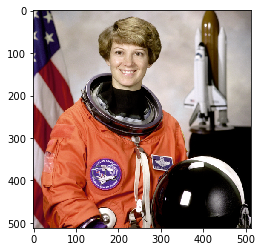

In [3]:
# Reading an image
image = io.imread("astronaut.png")

# Showing the dimensions
print("Dimensiones de la imagen: {}".format(image.shape))

# Visualization
plt.imshow(image)

>> Image saved successfully!


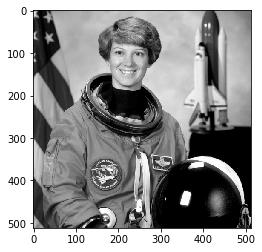

In [4]:
# Grayscale transformation
image_gray = rgb_to_grayscale(image)

# Visualization and saving
save_image(image=image_gray, name='astronaut_grayscale', _format='png')
plt.imshow(image_gray, cmap='gray')

>> Image saved successfully!


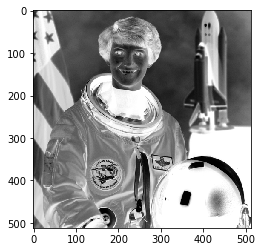

In [5]:
# Negativo para Escala de Grises (sin normalizar)
# En caso de estar normalizado -> Reemplazar 255 por 1
image_negative = 255 - image_gray
plt.imshow(image_negative, cmap='gray')
save_image(image=image_negative, name='astronaut_negative', _format='png')

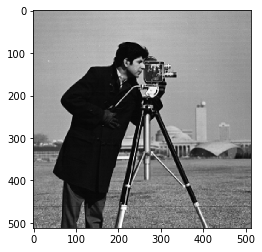

In [6]:
# A partir de una imagen, se calcula el histograma y la acumulacion.
# Luego mostrar las imagenes y los gráficos.
camera_image = data.camera()
plt.imshow(camera_image, cmap='gray')

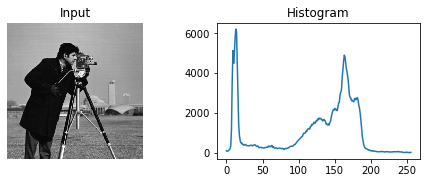

In [7]:
plot_histogram(camera_image)

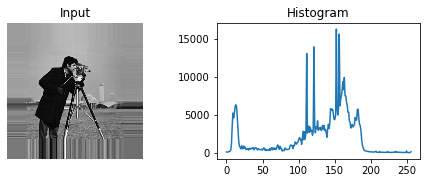

In [8]:
extended_image = resize_image(camera_image, 100)
plot_histogram(extended_image)

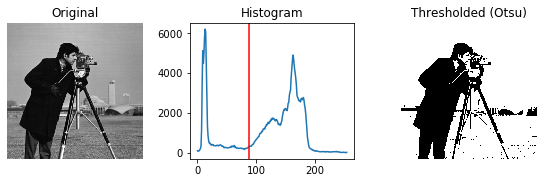

>> Image saved successfully!


In [9]:
binary_image_otsu, threshold = otsu_thresholding(camera_image)
plot_binarized_image(camera_image, binary_image_otsu, 'Otsu', threshold)
save_image(image=binary_image_otsu, name='cameraman_thresholded_otsu', _format='png')

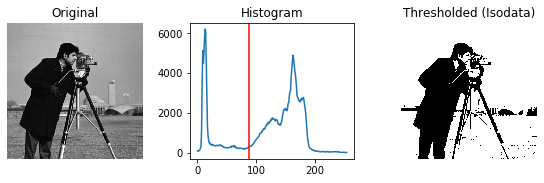

>> Image saved successfully!


In [10]:
binary_image_isodata, threshold = isodata_thresholding(camera_image)
plot_binarized_image(camera_image, binary_image_isodata, 'Isodata', threshold)
save_image(image=binary_image_isodata, name='cameraman_thresholded_isodata', _format='png')

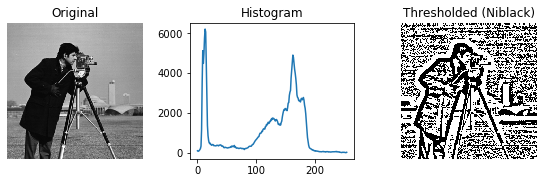

>> Image saved successfully!


In [11]:
binary_image_niblack = niblack_thresholding(camera_image)
plot_binarized_image(camera_image, binary_image_niblack, 'Niblack')
save_image(image=binary_image_niblack, name='cameraman_thresholded_niblack', _format='png')

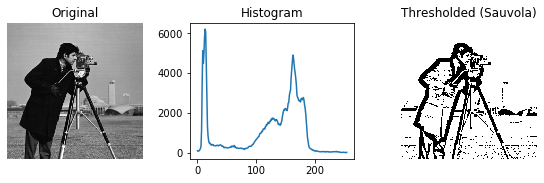

>> Image saved successfully!


In [12]:
binary_image_sauvola = sauvola_thresholding(camera_image)
plot_binarized_image(camera_image, binary_image_sauvola, 'Sauvola')
save_image(image=binary_image_sauvola, name='cameraman_thresholded_sauvola', _format='png')